In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Sequence, Any
from deepmeg.preprocessing.transforms import one_hot_encoder, zscore
from deepmeg.data.datasets import EpochsDataset
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchmetrics
from deepmeg.training.callbacks import EarlyStopping, PrintingCallback, L2Reg
from deepmeg.utils.viz import plot_metrics
from functools import partial
from deepmeg.utils.convtools import compute_output_shape, conviter
import torch.nn.init as init
import math


gprob = lambda x, sigma=np.sqrt(1/5): np.exp(-(x - 1)**2/sigma**2)


def gen_3d_prob(
    center: tuple[int, int, int],
    shape: tuple[int, int, int],
    gprob: Callable[[int | Sequence, int | float], float | Sequence] = gprob
) -> np.ndarray:
    """
    Generate a 3D binary array with values determined by a probability function.

    Args:
        center (tuple[int, int, int]): The center coordinates of the probability function.
        shape (tuple[int, int, int]): The shape of the output array.
        gprob (callable[[int | Sequence, int | float], float | Sequence], optional): The probability function to use. Defaults to gprob.

    Returns:
        np.ndarray: The generated 3D binary array.
    """
    w, h, l = shape
    data = np.zeros(shape)

    i, j, k = np.meshgrid(
        np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij'
    )

    pi = gprob(1 - np.abs(i - center[0])/w)
    pj = gprob(1 - np.abs(j - center[1])/h)
    pk = gprob(1 - np.abs(k - center[2])/l)
    prob = pi * pj * pk

    mask = prob > np.random.random(size=shape)
    data[mask] = 1

    return data


def gen_3d_voxel(mask: np.ndarray, ratio: int | float = 2) -> np.ndarray:
    """
    Generate a 3D voxel based on a binary mask and random noise.

    Args:
        mask (np.ndarray): A 3D binary mask.
        ratio (int | float, optional): The ratio of the maximum intensity of the voxel to the maximum intensity of the mask.
            Defaults to 2.

    Returns:
        np.ndarray: A 3D voxel with the same shape as the mask, where the value at each voxel is the product of the
            corresponding value in the mask, the ratio, and a random number between 0 and 1.
    """
    noise = np.random.random(mask.shape)
    return (mask*ratio + 1)*noise


def plot_2d_projections(matrix: np.ndarray) -> plt.Figure:
    """
    Plot the mean projections of a 3D matrix along the X, Y, and Z axes.

    Args:
        matrix (np.ndarray): A 3D matrix to plot.

    Returns:
        plt.Figure: A matplotlib Figure object containing the 2D projections along the X, Y, and Z axes.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(matrix.mean(axis=0))
    ax2.imshow(matrix.mean(axis=1))
    ax3.imshow(matrix.mean(axis=2))
    return fig


def gen_3d_samples(
    shape: tuple[int, int, int],
    center: tuple[int, int, int],
    n_samples: int,
    maskgen: Callable[[int | Sequence, int | float], float | Sequence] = gprob,
    datagen: Callable[[np.ndarray, int | float], np.ndarray] = gen_3d_voxel,
) -> np.ndarray:
    """
    Generate a 3D dataset of samples by sampling 3D binary masks and applying a voxel generation function.

    Args:
        shape (tuple[int, int, int]): The shape of the 3D binary masks to generate.
        center (tuple[int, int, int]): The center of the 3D binary masks to generate.
        n_samples (int): The number of 3D binary masks to generate and apply the voxel generation function.
        maskgen (Callable[[int | Sequence, int | float], float | Sequence], optional): The function used to generate the 3D binary masks.
            Defaults to gprob.
        datagen (Callable[[np.ndarray, int | float], np.ndarray], optional): The function used to generate the 3D voxel from the 3D binary masks.
            Defaults to gen_3d_voxel.

    Returns:
        np.ndarray: A 4D numpy array of shape (n_samples, *shape), where each element is a voxel generated by applying the
            voxel generation function to a binary mask generated by the mask generation function.
    """
    return np.array([
        datagen(gen_3d_prob(center, shape, maskgen))
        for _ in range(n_samples)
    ])


class ConvBlock(nn.Module):
    '''A module that implements a repetitive block of convolutional layer, batch normalization, nonlinearity, and dropout.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (Union[int, Tuple[int, int, int]]): Size of the convolutional kernel. If a single integer is given, the kernel will have the same size in all dimensions.
        stride (Union[int, Tuple[int, int, int]]): Stride of the convolution. If a single integer is given, the stride will be the same in all dimensions. Default: 1
        padding (Union[int, Tuple[int, int, int]]): Zero-padding added to all three sides of the input. If a single integer is given, the padding will be the same in all dimensions. Default: 0
        dilation (Union[int, Tuple[int, int, int]]): Spacing between kernel elements. If a single integer is given, the dilation will be the same in all dimensions. Default: 1
        drop (float): Dropout probability. Default: 0.0
        nonlinearity (nn.Module): Nonlinearity applied after batch normalization. Default: nn.ReLU()

    Attributes:
        conv (nn.Conv3d): Convolutional layer.
        bn (nn.BatchNorm3d): Batch normalization layer.
        nonlin (nn.Module): Nonlinearity applied after batch normalization.
        drop (nn.Dropout): Dropout layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor: Performs forward pass through the module.

    Returns:
        torch.Tensor: Tensor of shape (N, C, D_out, H_out, W_out) representing the output of the module.
    '''
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, drop=0.0, nonlinearity=nn.ReLU()):
        super().__init__()
        self.conv = nn.Conv3d(
            in_channels, out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation
        )
        self.bn = nn.BatchNorm3d(out_channels)
        self.nonlin = nonlinearity
        self.drop = nn.Dropout(p=drop)

    def forward(self,x):
        '''Performs forward pass through the module.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, D_in, H_in, W_in).

        Returns:
            torch.Tensor: Output tensor of shape (N, C, D_out, H_out, W_out).
        '''
        x = self.conv(x)
        x = self.bn(x)
        return self.drop(self.nonlin(x))


def compute_kernel_side(
    original_side: int,
    convolved_side: int,
    stride: int = 1,
    padding: int = 0,
    dilration: int = 1
):
    """
    Compute the size of a kernel for a given convolutional layer based on its input and output size and other parameters.

    Args:
    original_side (int): The size of the input along one dimension (e.g., height or width).
    convolved_side (int): The size of the output of the convolutional layer along the same dimension.
    stride (int): The stride of the convolutional layer (default: 1).
    padding (int): The padding size of the convolutional layer (default: 0).
    dilration (int): The dilation of the convolutional layer (default: 1).

    Returns:
    int: The size of the kernel for the convolutional layer along the given dimension.
    """
    return int((original_side + 2*padding - 1 - stride*(convolved_side - 1))/dilration + 1)

def compute_out_side(
    original_side: int,
    kernel_side: int,
    stride: int = 1,
    padding: int = 0,
    dilration: int = 1
):
    """
    Computes the output size of a convolution layer given its input size, kernel size, stride, padding, and dilation.

    Args:
        original_side (int): The size of the input feature map.
        kernel_side (int): The size of the convolution kernel.
        stride (int, optional): The stride of the convolution operation. Defaults to 1.
        padding (int, optional): The padding of the convolution operation. Defaults to 0.
        dilation (int, optional): The dilation rate of the convolution operation. Defaults to 1.

    Returns:
        int: The size of the output feature map after applying the convolution operation.
    """
    return int((original_side + 2*padding - dilration*(kernel_side - 1) - 1)/stride + 1)


class VGG3D(BaseModel):
    """
    A 3D version of the VGG neural network architecture. Each convolution reduces each dimension by half.

    Parameters:
        shape (int): The size of the input tensor in the form of (z, y, x).
        n_conv_blocks (int): The number of convolutional blocks.
        max_pool_size (tuple[int, int, int]): The size of the max pooling kernel in the form of (z, y, x).
        n_fc_layers (int): The number of fully connected layers.
        n_classes (int): The number of output classes.
        convblocks_kwargs (dict): Optional arguments to pass to each ConvBlock instance.

    Raises:
        ValueError: If the size of any plane in the shape is reduced to 0 by the convolutional layers.

    Attributes:
        conv_blocks (nn.ModuleList): A list of ConvBlock instances.
        max_pool (nn.MaxPool3d): A 3D max pooling layer.
        fc_layers (nn.ModuleList): A list of fully connected layers.
        num_features (int): The total number of features in the final convolutional layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor:
            Computes the forward pass of the network.

    """
    def __init__(
        self,
        shape: int,
        n_conv_blocks: int,
        max_pool_size: tuple[int, int, int],
        n_fc_layers: int,
        n_classes: int,
        convblocks_kwargs: dict = None,
    ):
        super().__init__()

        if convblocks_kwargs is None:
            convblocks_kwargs = dict()

        self.conv_blocks = nn.ModuleList()
        self.max_pool = nn.MaxPool3d(max_pool_size, max_pool_size)
        self.fc_layers = nn.ModuleList()

        for _ in range(n_conv_blocks):

            self.conv_blocks.append(
                ConvBlock(
                    1, 1,
                    kernel_size=[compute_kernel_side(plane, plane//2) for plane in shape],
                    **convblocks_kwargs
                )
            )
            shape = [plane//2 for plane in shape]
            shape = [
                compute_out_side(plane, mp, mp)
                for plane, mp in zip(shape, max_pool_size)
            ]

            if any([plane == 0 for plane  in shape]):
                raise ValueError('Convolutional layers have reduced the input to 0')

        self.num_features = np.prod(shape)

        for i in range(n_fc_layers):
            if i != n_fc_layers - 1:
                self.fc_layers.append(
                    nn.Linear(self.num_features, self.num_features)
                )
            else:
                self.fc_layers.append(
                    nn.Linear(self.num_features, n_classes)
                )


    def forward(self, x: torch.Tensor):
        """
        Forward pass of the VGG3D model.

        Args:
            x (torch.Tensor): Input tensor of shape `(batch_size, channels, depth, height, width)`.

        Returns:
            torch.Tensor: Output tensor of shape `(batch_size, num_classes)`.
        """
        x = torch.unsqueeze(x, 1)

        for conv_block in self.conv_blocks:
            x = conv_block(x)
            x = self.max_pool(x)

        x = torch.flatten(x, start_dim=1)

        for fc_layer in self.fc_layers:
            x = fc_layer(x)

        return x


class ResConv3D(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        input_size,
        kernel_size,
        stride=1,
        padding=0,
        bias=True,
    ):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.kernel_size = kernel_size
        self.input_size = input_size
        self.stride = stride
        self.padding = padding
        self.wave1 = nn.Parameter(torch.empty(self.in_channels, self.kernel_size[0], self.input_size[1], self.input_size[2], self.out_channels))
        self.wave2 = nn.Parameter(torch.empty(self.in_channels, self.input_size[0], self.kernel_size[1], self.input_size[2], self.out_channels))
        self.wave3 = nn.Parameter(torch.empty(self.in_channels, self.input_size[0], self.input_size[1], self.kernel_size[2], self.out_channels))

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Reset the layer parameters.
        Uses the Kaiming initialization method for the weight matrix and a uniform initialization method for the bias vector.
        """
        init.kaiming_uniform_(self.wave1, a=math.sqrt(5))
        init.kaiming_uniform_(self.wave2, a=math.sqrt(5))
        init.kaiming_uniform_(self.wave3, a=math.sqrt(5))

        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.wave1)

            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)


    def forward(self, x):
        convargs = ((x.shape[-3], x.shape[-2], x.shape[-1]), self.kernel_size, self.padding, self.stride)
        out_shape = compute_output_shape(*convargs)
        out_tensor = torch.zeros(x.shape[0], self.out_channels, *out_shape)

        for n_neuron in range(self.out_channels):
            for p, q, k in conviter(*convargs):
                x_slice = x[:, :, p[0], p[1], p[2]]
                w1_slice = self.wave1[:, k[0], p[1], p[2], n_neuron]
                w2_slice = self.wave2[:, p[0], k[1], p[2], n_neuron]
                w3_slice = self.wave3[:, p[0], p[1], k[2], n_neuron]
                # res = torch.unsqueeze(torch.unsqueeze((w1_slice*w2_slice*x_slice).sum((1, 2, 3)), -1), -1)
                # res = torch.unsqueeze(torch.unsqueeze(((w1_slice+w2_slice)*x_slice).sum((1, 2, 3)), -1), -1)
                # print(w1_slice.shape, w2_slice.shape, w3_slice.shape, x_slice.shape)
                res = ((w1_slice + w2_slice + w3_slice)*x_slice).sum((1, 2, 3, 4))
                # res = ((w1_slice + w2_slice)*x_slice).sum((1, 2, 3))
                # print(torch.squeeze(res).item(),w1_slice.item(), w2_slice.item(), x_slice.item())
                # print(out_tensor[:, n_neuron, q[-2], q[-1]].shape, res.shape)
                out_tensor[:, n_neuron, q[-3], q[-2], q[-1]] = res

        return out_tensor


class CC2(BaseModel):
    def __init__(
        self,
        in_channels,
        out_channels,
        input_size,
        kernel_size,
        maxpool_size,
        n_classes: int,
        stride=1,
        padding=0,
        dropout=None
    ):
        super().__init__()
        self.n_classes = n_classes
        self.rc = ResConv3D(in_channels, out_channels, input_size, kernel_size, stride, padding)
        self.dp = None if dropout is None else nn.Dropout(dropout)
        convargs = (input_size, kernel_size, padding, stride)
        self.convout_shape = compute_output_shape(*convargs)
        self.maxpool = nn.MaxPool3d((maxpool_size, maxpool_size, maxpool_size), maxpool_size)
        convargs = (self.convout_shape, (maxpool_size, maxpool_size, maxpool_size), 0, maxpool_size)
        self.maxpool_shape = compute_output_shape(*convargs)
        self.num_features = out_channels*np.prod(self.maxpool_shape)
        self.linear = nn.Linear(self.num_features, self.n_classes)


    def forward(self, x: torch.Tensor):
        x = torch.unsqueeze(x, 1)

        x = self.rc(x)
        if self.dp:
            x = self.dp(x)
        x = self.maxpool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)

        return x

In [2]:
import nibabel as nb
data_dir = '/home/user/mne_data/fmri_data/'

Y = list()
X = list()

for run in os.listdir(data_dir):
    run_path = os.path.join(data_dir, run)
    for scan in os.listdir(run_path):
        datapath = os.path.join(run_path, scan)
        scan_type = scan.split('_')[0]
        X.append(np.array(nb.load(datapath).dataobj))
        if scan_type == 'video':
            Y.append(0)
        elif scan_type == 'word':
            Y.append(1)
        else:
            raise ValueError(f'Unknown scan type: {scan_type}')

X = np.array(X)
Y = one_hot_encoder(np.array(Y))

In [10]:
X[0].shape

(97, 114, 97)

In [3]:
import numpy as np

def pad_matrix(matrix):
    """
    Pad a matrix with zeros to match the largest side.

    Args:
    - matrix: A numpy array representing the input matrix.

    Returns:
    - padded_matrix: A numpy array with the padded matrix.
    """

    max_side = max(matrix.shape)
    pad_widths = [(0, max_side - dim) for dim in matrix.shape]
    padded_matrix = np.pad(matrix, pad_widths, mode='constant')

    return padded_matrix

In [4]:
dataset = EpochsDataset((X, Y), savepath='../datasets/fmri', transform = zscore)
dataset.save('../data/fmri.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [2]:
dataset = EpochsDataset.load('../data/fmri.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

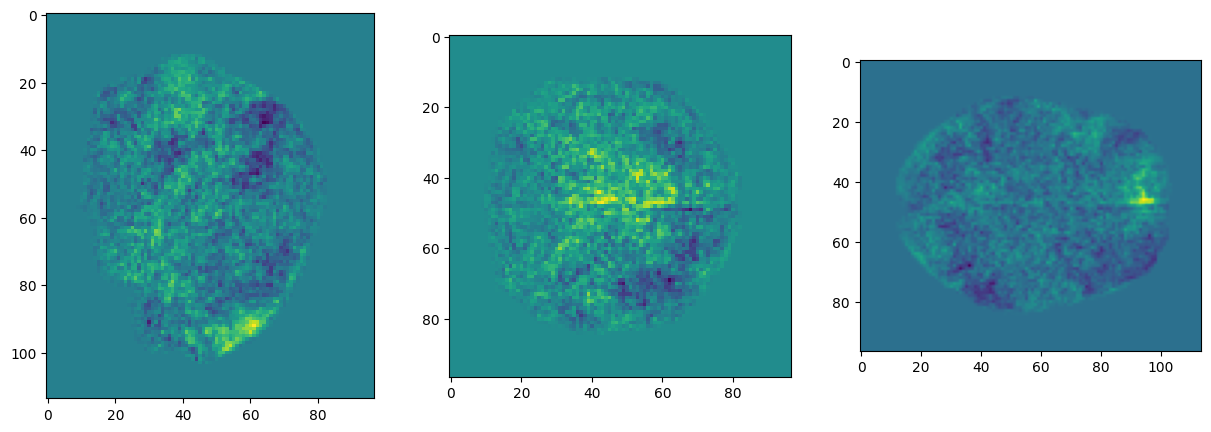

In [3]:
fig = plot_2d_projections(train[np.random.randint(0, len(train))][0])

In [5]:

X, Y = next(iter(DataLoader(train)))

In [7]:
model = CC2(
    in_channels=1,
    out_channels=1,
    input_size=X[0].shape,
    kernel_size=(10, 10, 10),
    maxpool_size=5,
    n_classes=3,
    stride=2,
    dropout=.5
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        L2Reg(
            [
                'rc.wave1', 'rc.wave2', 'rc.wave3'
            ],
            0.01
        ),
        EarlyStopping(monitor='loss_val', restore_best_weights=True, patience=10)
    ]
)

In [ ]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

In [8]:
history = model.fit(train, n_epochs=150, batch_size=50, val_batch_size=10)
plot_metrics(history)

  0%|          | 0/150 [00:00<?, ?it/s]

: 

: 

In [ ]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

In [40]:
x = X[0]

In [41]:
x.shape

(114, 114, 114)